<a href="https://colab.research.google.com/github/jeonghojo00/SpeechRecognition/blob/main/SpeechRecognition_MedicalSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target 1: Convert Wav file into Text
 Target 2: Analyze symptoms with text

## Step 0. Connect to Google Drive

In [25]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Change current directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/SpeechRecognition/MedicalSpeech')


In [27]:
# Import Overview csv file
import pandas as pd


#Analyze Data
def explore_data(df):
    print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns.")
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print(df.info())

filename = "overview-of-recordings.csv"
overview = pd.read_csv(filename)
explore_data(overview)

The data contains 6661 rows and 13 columns.


Dataset columns: Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                      

## Step 1. Preprocessing

##### Preprocessing includes following actions:
1. Load audio file
2. Load csv file
3. Convert audio file into spectrogram feature, mfcc feature
4/ 

### Step 1-1. Import train, validate, and test corpus json files

In [28]:
import json

f = open('train_corpus.json',)
train_corpus = json.load(f)

f = open('valid_corpus.json',)
validate_corpus = json.load(f)

f = open('test_corpus.json',)
test_corpus = json.load(f)
  

### Step 1-2. Define functions for various wavelengths

In [29]:
# Transform wav into signal and rate
import librosa, librosa.display

signal, sr = librosa.load(train_corpus[0]["key"], sr=22050)

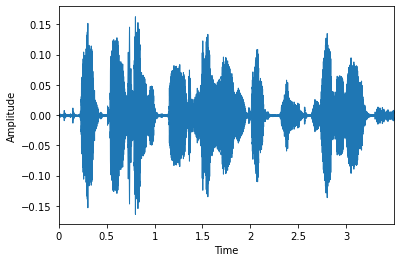

In [30]:
# WaveForm

import matplotlib.pyplot as plt

librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [31]:
import librosa, librosa.display
import numpy as np

def to_spectrogram(file_path, n_fft=320, sr=22050, plot=False):
    # Transform wav into signal and rate
    signal, sr = librosa.load(file_path, sr=sr)

    # Spectrogram

    #n_fft=2048: Number of samples per fft
    #hop_length = 512 # Amount we shift to the right

    hop_length = 128

    stft = librosa.core.stft(signal, hop_length=hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)

    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    if plot:
        # Plot the result
        librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
    
    tr_log_spectrogram = np.transpose(log_spectrogram)
    return tr_log_spectrogram

In [32]:
import numpy as np
def normalize(feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        feats_mean = np.mean(log_spectrogram, axis=0)
        feats_std = np.std(log_spectrogram, axis=0)
        return (feature - feats_mean) / (feats_std + eps)

In [33]:
def to_mfcc(file_path, sr=22050, plot=False):
    # MFCCs
    signal, sr = librosa.load(train_corpus[0]["key"], sr=sr)
    MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

    if plot:
        librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()


In [34]:
def to_spectrum(file_path, sr=22050, plot=False):
    # Spectrum
    # Transform wav into signal and rate
    signal, sr = librosa.load(train_corpus[0]["key"], sr=sr)

    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))

    # Because once we pass over the half, we repeat the same information. we use only the first half
    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    if plot:

        plt.plot(left_frequency, left_magnitude)
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.show()
    

### Step 1.3. Prepare Datasets

In [35]:
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

def convert_inputs_to_ctc_format(audio_path, feature, text, samplerate=22050):
    # Convert auido file into audio feature in 3D
    ## Load audio file into selected feature
    if feature == "spectrogram":
        inputs = to_spectrogram(audio_path, sr=samplerate)
    elif feature == "mfcc":
        inputs = to_mfcc(audio_path, sr=samplerate)
    elif feature == "spectrum":
        inputs = to_spectrum(audio_path, sr=samplerate)
    
    ## Change inputs into 3D
    train_inputs = np.asarray(inputs[np.newaxis, :])
    train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
    train_seq_len = [train_inputs.shape[1]]

    # Get only the words between [a-z] and replace period for none
    original = ' '.join(text.strip().lower().split(' '))\
                  .replace('.', '').replace('?', '').replace(',','').replace("'", '').replace('!', '').replace('-', '')
    audioText = speech["text"].lower()
    audioText = re.sub('[^a-zA-Z0-9 \n]', '', audioText)
    audioText = audioText.strip()
    targets = original.replace(' ', '  ')
    targets = targets.split(' ')

    # Adding blank label
    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

    # Transform char into index
    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                          for x in targets])

    return train_inputs, train_seq_len, targets, original




In [36]:
def pad_sequences(sequences, maxlen=None, dtype=np.float32,
                  padding='post', truncating='post', value=0.):
    '''Pads each sequence to the same length: the length of the longest
    sequence.
        If maxlen is provided, any sequence longer than maxlen is truncated to
        maxlen. Truncation happens off either the beginning or the end
        (default) of the sequence. Supports post-padding (default) and
        pre-padding.
        Args:
            sequences: list of lists where each element is a sequence
            maxlen: int, maximum length
            dtype: type to cast the resulting sequence.
            padding: 'pre' or 'post', pad either before or after each sequence.
            truncating: 'pre' or 'post', remove values from sequences larger
            than maxlen either in the beginning or in the end of the sequence
            value: float, value to pad the sequences to the desired value.
        Returns
            x: numpy array with dimensions (number_of_sequences, maxlen)
            lengths: numpy array with the original sequence lengths
    '''
    lengths = np.asarray([len(s) for s in sequences], dtype=np.int64)

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x, lengths

In [37]:
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

def decode_text(y_predict, original):
    # Decode list of integer into the text
    aligned_original_string = ''
    aligned_decoded_string = ''

    str_decoded = ''.join([chr(x) for x in np.asarray(y_predict) + FIRST_INDEX])

    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
    maxlen = max(len(original), len(str_decoded))
    aligned_original_string += str(original).ljust(maxlen)
    aligned_decoded_string += str(str_decoded).ljust(maxlen)

    print('- Original: %s' % (aligned_original_string))
    print('- Decoded : %s' % (aligned_decoded_string))



In [38]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)

    return indices, values, shape

## Step 2. Build Model

In [39]:
'''
Recurrent Neural Network works weell in sequential data better than Feed Forward Neural Network
Because speech is sequential data, we use Recurrent Neural Network
'''


'\nRecurrent Neural Network works weell in sequential data better than Feed Forward Neural Network\nBecause speech is sequential data, we use Recurrent Neural Network\n'

In [40]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model


#### AutoGenerator function

In [41]:
RNG_SEED = 123


class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False, n_fft=320):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """
        self.n_fft = n_fft
        self.feat_dim = int(n_fft/2) +1
        '''
        self.feat_dim = calc_feat_dim(window, max_freq)
        '''
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]
        print("")
        print("Current Index: ", self.cur_train_index)
        print("shape of first feature:", features[0].shape)
        print(features[0])

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        print("get_batch starts")
        print("minibatch size: ", self.minibatch_size)
        print("number of intpus: ", len(inputs["the_input"]))
        print("shape of first input: ", inputs["the_input"][0].shape)
        print("shape of second input: ", inputs["the_input"][1].shape)
        print("shape of first labels: ", inputs["the_labels"][0].shape)
        print("shape of second labels: ", inputs["the_labels"][1].shape)

        print("get_batch ends")
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def data_for_fit(self, partition):
        """Obtain a dataset for partition
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in audio_paths]
        labels = np.array([text_to_int_sequence(a) for a in texts])

        return features, labels

            
    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        import re

        f = open(desc_file)
        file_loaded = json.load(f)
        
        audio_paths, durations, texts = [], [], []
        for speech in file_loaded:
            if float(speech["duration"]) > self.max_duration:
                continue
            audio_paths.append(speech["key"])
            durations.append(speech["duration"])

            audioText = speech["text"].lower()
            audioText = re.sub('[^a-zA-Z0-9 \n]', '', audioText)
            audioText = audioText.strip()
            '''
            audioText = speech["text"].lower().replace('.', '').replace('?', '').replace(',','').replace("'", '').replace('!', '').replace('-', '')
            '''
            audioText = convert_num_to_words(audioText)
            texts.append(audioText)

        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return to_spectrogram(audio_clip, n_fft=self.n_fft)
            '''
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
            '''

        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)


In [42]:
pip install python_speech_features

In [43]:
pip install num2words

In [44]:
import json
import numpy as np
import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [45]:
"""
Defines two dictionaries for converting 
between text and integer sequences.
"""

char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# the "blank" character is mapped to 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [46]:
import numpy as np
import soundfile
from numpy.lib.stride_tricks import as_strided
import num2words #!pip install num2words

def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

def convert_num_to_words(utterance):
      utterance = ' '.join([num2words.num2words(i) if i.isdigit() else i for i in utterance.split()])
      return utterance

def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def conv_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride


def get_spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        print(audio.ndim)
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2

        if max_freq > sample_rate / 2:
            print("Error at: ", filename)
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            print("Error at: ", filename)
            raise ValueError("step size must not be greater than window size")

        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = get_spectrogram(audio, fft_length=fft_length, sample_rate=sample_rate, hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    
    spectroGram = np.transpose(np.log(pxx[:ind, :] + eps))

    print("Filename         : ", filename)
    print("PXX shape: ", pxx.shape, ", IND: ", ind, ", freq: ", freqs.shape, ", Max_freq: ", max_freq)
    print("Sample Rate: ", sample_rate, ", Hop Length: ", hop_length, ", FFT Length: ", fft_length)
    print("Spectrogram shape: ", spectroGram.shape)

    return spectroGram

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    print(int_sequence)
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text



#### Function: Model Build

In [47]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [66]:
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

def final_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Specify the layers in your network
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    dropout1 = Dropout(0.3)(bn_cnn)
    simp_rnn1 = GRU(units, return_sequences=True)(dropout1)
    bn_rnn1 = BatchNormalization(name='bn_conv_1d1')(simp_rnn1)
    
    dropout2 = Dropout(0.3)(bn_rnn1)
    simp_rnn2 = GRU(units, return_sequences=True)(dropout2)
    bn_rnn2 = BatchNormalization(name='bn_conv_1d2')(simp_rnn2)

    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn2)

    # TODO: Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # TODO: Specify model.output_length
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    print("Output length of model: ", model.output_length)
    return model

In [49]:
model = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
gru (GRU)                    (None, None, 200)         241200    
_________________________________________________________________
bn_conv_1d1 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0     

In [50]:
import _pickle as pickle

from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

input_to_softmax = model
train_json='train_corpus.json'
valid_json='valid_corpus.json'
minibatch_size=20
spectrogram=True
mfcc_dim=13
optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
epochs=20
verbose=1
sort_by_duration=False
max_duration=10.0

In [ ]:
audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)

In [ ]:
audio_gen.load_train_data(train_json) # Load Metat data from json and save in lists, then fit_train()
audio_gen.load_validation_data(valid_json)

In [ ]:
num_train_examples=len(audio_gen.train_audio_paths)
print("Printing number of Training Data")
print("Number of train data: ", num_train_examples)
steps_per_epoch = num_train_examples//minibatch_size
print("Steps per epoch: ", steps_per_epoch)

Printing number of Training Data
Number of train data:  169
Steps per epoch:  8


In [ ]:
 # calculate validation_steps
num_valid_samples = len(audio_gen.valid_audio_paths)
print("Printing number of Validation Data")
print("Number of train data: ", num_valid_samples) 
validation_steps = num_valid_samples//minibatch_size
print("Steps per epoch: ", validation_steps)

Printing number of Validation Data
Number of train data:  149
Steps per epoch:  7


In [ ]:
# add CTC loss to the NN specified in input_to_softmax
model = add_ctc_loss(input_to_softmax) #Added Ctc loss

# CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [ ]:
if not os.path.exists('results'):
        os.makedirs('results')

In [ ]:
# Run by Fit

epochs = 10
verbose = 1
pickle_path = 'model_end.pickle' 
save_model_path ='model_end.h5'

checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)
train_x, train_y = audio_gen.data_for_fit("train")
valid_x, valid_y = audio_gen.data_for_fit("valid")

hist = model.fit(x = train_x,
                 y = train_y,
                 steps_per_epoch=steps_per_epoch,
                 epochs=epochs,
                 validation_data=(valid_x, valid_y),
                 validation_steps=validation_steps,
                 callbacks=[checkpointer], verbose=verbose)

with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

In [ ]:
las# Run by Fit-Generator

epochs=10
verbose=1
pickle_path = 'model_end.pickle' 
save_model_path ='model_end.h5'

# add checkpointer
checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)

hist = model.fit_generator(generator=audio_gen.next_train(), 
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs, 
                           validation_data=audio_gen.next_valid(), 
                           validation_steps=validation_steps,
                           callbacks=[checkpointer], verbose=verbose)

with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Current Index:  0
shape of first feature: (603, 161)
[[-0.18037342 -0.3175863  -0.42148226 ... -0.20322227 -0.18552203
  -0.18033576]
 [-1.0269743  -0.66149443 -0.7459992  ... -0.49555477 -0.47519046
  -0.46876925]
 [-0.9437248  -1.104789   -0.5374332  ... -0.49555477 -0.47519046
  -0.46876925]
 ...
 [-1.1679637  -1.3224343  -0.7524987  ... -0.49555477 -0.47519046
  -0.46876925]
 [-1.0782385  -1.0681705  -1.0878954  ... -0.49555477 -0.47519046
  -0.46876925]
 [-0.8275997  -0.8754889  -0.7653985  ...  0.22042473  0.24840595
   0.25148246]]
get_batch starts
minibatch size:  20
number of intpus:  20
shape of first input:  (1309, 161)
shape of second input:  (1309, 161)
get_batch ends
Epoch 1/10
1/8 [==>...........................] - ETA: 24s - loss: 953.9156
Current Index:  20
shape of first feature: (765, 161)
[[-0.21031168 -0.4559485  -0.6435662  ... -0.0154371   0.00844488
   0.01515031]
 [-1.0071806  -1.0217551  -0.83634126 ... -0.0154371   0.00844488
   0.01515031]
 [-1.0071806  -0.

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
from keras import backend as K
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [ ]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200), 
                model_path='./results/model_end.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
bn_conv_1d1 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0   

KeyError: ignored

##Testing

# 새 섹션

In [ ]:
train_data = train_corpus[0:2]
valid_data = validate_corpus[0:3]

In [ ]:
import re 

def featurize(audio_clip, n_fft = 320):
    """ For a given audio clip, calculate the corresponding feature
    Params:
        audio_clip (str): Path to the audio clip
    """
    return to_spectrogram(audio_clip, n_fft=n_fft)


def normalize(feature, eps = 1e-14):
    feat_mean = np.mean(feature, axis=0)
    feat_std = np.std(feature, axis=0)
    return (feature-feat_mean) / (feat_std + eps)


def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:

        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence


def data_for_fit(corpus):

    """Obtain a dataset for partition
    """
    audio_paths = list()
    texts = list()
    labels = list()

    for item in corpus:
        audio_paths.append(item["key"])

        audioText = item["text"].lower()
        audioText = re.sub('[^a-zA-Z0-9 \n]', '', audioText)
        audioText = audioText.strip()
        texts.append(audioText)

    features = [normalize(featurize(a)) for a in audio_paths]

    for text in texts:
        labels.append(text_to_int_sequence(text))

    return features, labels

In [ ]:
model = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
gru_6 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
bn_conv_1d1 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0   

In [ ]:
import _pickle as pickle

from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

input_to_softmax = model
train_json='train_corpus.json'
valid_json='valid_corpus.json'
minibatch_size=20
spectrogram=True
mfcc_dim=13
optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
epochs=20
verbose=1
sort_by_duration=False
max_duration=10.0

In [ ]:
audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)

In [ ]:
audio_gen.load_train_data(train_json) # Load Metat data from json and save in lists, then fit_train()
audio_gen.load_validation_data(valid_json)

In [ ]:
# add CTC loss to the NN specified in input_to_softmax
model = add_ctc_loss(input_to_softmax) #Added Ctc loss

# CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [ ]:
# Run by Fit

epochs = 10
verbose = 1
pickle_path = 'model_end.pickle' 
save_model_path ='model_end.h5'

checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)
train_x, train_y = data_for_fit(train_data)
valid_x, valid_y = data_for_fit(valid_data)

hist = model.fit(x = train_x,
                 y = train_y,
                 steps_per_epoch=steps_per_epoch,
                 epochs=epochs,
                 validation_data=(valid_x, valid_y),
                 validation_steps=validation_steps,
                 callbacks=[checkpointer], verbose=verbose)

ValueError: ignored

## CTC Loss practice

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=7abad4dfa5771a1238e12a0fc1e866b72027fa79d8b5cde33270d7b577ad46ec
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
#  Compatibility imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from python_speech_features import mfcc

import time

import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np

In [ ]:
# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

In [ ]:
# Some configs
num_features = 13
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

In [ ]:
# Hyper-parameters
num_epochs = 40
num_hidden = 50
num_layers = 1
batch_size = 2
initial_learning_rate = 1e-2
momentum = 0.9

In [ ]:
num_examples = 16
num_batches_per_epoch = int(num_examples/batch_size)

In [ ]:
features = list()
texts = list()

for item in train_corpus:
    path = item["key"]
    features.append(to_spectrogram(path))
    texts.append(item["text"])

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
train_features = np.array(features)

In [ ]:
# Tranform in 3D array
train_inputs = np.asarray(inputs[np.newaxis, :])
print(train_inputs.shape)

(1, 699, 13)


In [ ]:
pip install num2words

     |████████████████████████████████| 102kB 5.6MB/s 


In [52]:
import num2words #pip install num2words required

# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

# Some configs
num_features = 161
num_units=50 # Number of units in the LSTM cell
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1


def convert_num_to_words(utterance):
      utterance = ' '.join([num2words.num2words(i) if i.isdigit() else i for i in utterance.split()])
      return utterance

def convert_inputs_to_ctc_format(audio_path, feature, text, samplerate=22050):
    # Convert auido file into audio feature in 3D
    ## Load audio file into selected feature
    if feature == "spectrogram":
        inputs = to_spectrogram(audio_path, sr=samplerate)
    elif feature == "mfcc":
        inputs = to_mfcc(audio_path, sr=samplerate)
    elif feature == "spectrum":
        inputs = to_spectrum(audio_path, sr=samplerate)
    
    ## Change inputs into 3D
    train_inputs = inputs
    train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
    train_seq_len = [train_inputs.shape[1]]

    # Get only the words between [a-z] and replace period for none
    text = convert_num_to_words(text)
    original = ' '.join(text.strip().lower().split(' ')).replace('.', '').replace('?', '').replace(',','').replace('"', '').replace("'", '').replace('!', '').replace('-', '').replace(':', '').replace(';', '')
    targets = original.replace(' ', '  ')
    targets = targets.split(' ')

    # Adding blank label
    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

    # Transform char into index
    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX for x in targets])

    return train_inputs, train_seq_len, targets, original


### Making dataset for CTC Loss practice

In [61]:
train_audio = list()
train_texts = list()

for item in train_corpus:
    path = item["key"]
    feature = "spectrogram"
    text = item["text"]
    inputs, seq_len, target, original = convert_inputs_to_ctc_format(path, feature, text)
    train_audio.append(inputs)
    train_texts.append(target)


In [62]:
valid_audio = list()
valid_texts = list()

for item in validate_corpus:
    path = item["key"]
    feature = "spectrogram"
    text = item["text"]
    inputs, seq_len, target, original = convert_inputs_to_ctc_format(path, feature, text)
    valid_audio.append(inputs)
    valid_texts.append(target)


In [63]:
train_inputs = np.asarray(train_audio)
train_targets = np.asarray(train_texts)
valid_inputs = np.asarray(valid_audio)
valid_targets = np.asarray(valid_texts)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [106]:
'''
inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
'''
def combineData(inputs, targets):
    input_length = np.zeros([len(inputs),1])
    label_length = np.zeros([len(inputs),1])

    for i in range(len(inputs)):
        input_length[i] = len(inputs[i])
        label_length[i] = len(targets[i])

    inputs = {'the_input': inputs, 
              'the_labels': targets, 
              'input_length': input_length,
              'label_length': label_length 
              }
    return inputs

In [107]:
trainDataset = combineData(train_inputs, train_targets)
validDataset = combineData(valid_inputs, valid_targets)

In [108]:
trainDataset

{'input_length': array([[1706.],
        [ 633.],
        [1191.],
        [ 561.],
        [ 721.],
        [ 417.],
        [ 662.],
        [ 881.],
        [ 794.],
        [1297.],
        [ 769.],
        [2014.],
        [2117.],
        [ 780.],
        [ 750.],
        [1088.],
        [1073.],
        [ 677.],
        [ 647.],
        [ 561.],
        [1441.],
        [ 561.],
        [ 881.],
        [ 515.],
        [ 753.],
        [ 412.],
        [ 641.],
        [ 865.],
        [ 603.],
        [ 209.],
        [ 618.],
        [ 737.],
        [ 809.],
        [ 769.],
        [1426.],
        [1324.],
        [2088.],
        [ 853.],
        [ 833.],
        [ 412.],
        [ 486.],
        [ 529.],
        [1059.],
        [ 881.],
        [ 559.],
        [1132.],
        [ 677.],
        [ 603.],
        [ 750.],
        [1397.],
        [ 412.],
        [ 657.],
        [ 456.],
        [ 971.],
        [ 677.],
        [2823.],
        [ 397.],
        [ 662.]

In [64]:
graph = tf.Graph()

In [59]:
#  Compatibility imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import scipy.io.wavfile as wav
import numpy as np

from six.moves import xrange as range

try:
    from python_speech_features import mfcc
except ImportError:
    print("Failed to import python_speech_features.\n Try pip install python_speech_features.")
    raise ImportError

# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

# Some configs
num_features = 161
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 40
num_hidden = 50
num_layers = 1
batch_size = 2
initial_learning_rate = 1e-2
momentum = 0.9

num_examples = len(train_inputs)
num_batches_per_epoch = int(num_examples/batch_size)



In [81]:
from tensorflow import keras
from tensorflow.keras import layers

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [83]:
def dl_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    inputs = Input(name='the_input', shape=(None, input_dim))

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # TODO: Specify the layers in your network
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(inputs)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    dropout1 = Dropout(0.3)(bn_cnn)
    simp_rnn1 = GRU(units, return_sequences=True)(dropout1)
    bn_rnn1 = BatchNormalization(name='bn_conv_1d1')(simp_rnn1)
    
    dropout2 = Dropout(0.3)(bn_rnn1)
    simp_rnn2 = GRU(units, return_sequences=True)(dropout2)
    bn_rnn2 = BatchNormalization(name='bn_conv_1d2')(simp_rnn2)

    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    softmax_output = Dense(output_dim, activation = 'softmax', name="dense")(bn_rnn2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)
    optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)
    
    return model

In [84]:
# specify the model
model_end = dl_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

In [79]:
steps_per_epoch = len(train_inputs) // batch_size
validation_steps = len(valid_inputs) // batch_size 

hist = model.fit(x = train_inputs,
                 y = train_targets,
                 steps_per_epoch=steps_per_epoch,
                 epochs=epochs,
                 validation_data=(valid_inputs, valid_targets),
                 validation_steps=validation_steps,
                 verbose=verbose)

ValueError: ignored

In [70]:
def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

model = final_model(input_dim=num_features, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
gru_8 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
bn_conv_1d1 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 200)         0   

In [85]:
verbose=1

history = model.fit(
    x = train_inputs,
    y = train_targets,
    batch_size = 16,
    steps_per_epoch=len(train_inputs) // batch_size,
    epochs=epochs, 
    validation_data=(valid_inputs, valid_targets),
    validation_steps=len(valid_inputs) // batch_size)

ValueError: ignored

In [65]:


# THE MAIN CODE!

graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell
    # Stacking rnn cells
    cells = []
    for _ in range(num_layers):
        cell = tf.nn.rnn_cell.LSTMCell(num_units)  # Or LSTMCell(num_units)
        cells.append(cell)
    stack = tf.nn.rnn_cell.MultiRNNCell(cells)

    # The second output is the last state and we will no use that
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    # Tip: Try another initialization
    # see https://www.tensorflow.org/versions/r0.9/api_docs/python/contrib.layers.html#initializers
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    # Tip: Is tf.zeros_initializer the same?
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = tf.nn.ctc_loss(targets, logits, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.nn.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

with tf.Session(graph=graph) as session:
    # Initializate the weights and biases
    tf.global_variables_initializer().run()


    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch):

            # Getting the index
            indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]

            batch_train_inputs = train_inputs[indexes]
            # Padding input to max_time_step of this batch
            batch_train_inputs, batch_train_seq_len = pad_sequences(batch_train_inputs)

            # Converting to sparse representation so as to to feed SparseTensor input
            batch_train_targets = sparse_tuple_from(train_targets[indexes])

            feed = {inputs: batch_train_inputs,
                    targets: batch_train_targets,
                    seq_len: batch_train_seq_len}

            batch_cost, _ = session.run([cost, optimizer], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size


        # Shuffle the data
        shuffled_indexes = np.random.permutation(num_examples)
        train_inputs = train_inputs[shuffled_indexes]
        train_targets = train_targets[shuffled_indexes]

        # Metrics mean
        train_cost /= num_examples
        train_ler /= num_examples

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler, time.time() - start))

    # Decoding all at once. Note that this isn't the best way

    # Padding input to max_time_step of this batch
    batch_train_inputs, batch_train_seq_len = pad_sequences(train_inputs)

    # Converting to sparse representation so as to to feed SparseTensor input
    batch_train_targets = sparse_tuple_from(train_targets)

    feed = {inputs: batch_train_inputs,
            targets: batch_train_targets,
            seq_len: batch_train_seq_len
            }

    # Decoding
    d = session.run(decoded[0], feed_dict=feed)
    dense_decoded = tf.sparse_tensor_to_dense(d, default_value=-1).eval(session=session)

    for i, seq in enumerate(dense_decoded):

        seq = [s for s in seq if s != -1]

        print('Sequence %d' % i)
        print('\t Original:\n%s' % train_targets[i])
        print('\t Decoded:\n%s' % seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/40, train_cost = inf, train_ler = 0.875, time = 100.841
Epoch 2/40, train_cost = inf, train_ler = 1.989, time = 102.268
Epoch 3/40, train_cost = inf, train_ler = 1.496, time = 102.274
Epoch 4/40, train_cost = inf, train_ler = 1.443, time = 104.231
Epoch 5/40, train_cost = inf, train_ler = 2.037, time = 102.337
Epoch 6/40, train_cost = inf, train_ler = 1.531, time = 101.730
Epoch 7/40, train_cost = inf, train_ler = 1.084, time = 103.391
Epoch 8/40, train_cost = inf, train_ler = 1.341, time = 105.928
Epoch 9/40, train_cost = inf, train_ler = 1.227, time = 102.465
Epoch 10/40, train_cost = inf, train_ler = 1.101, time = 105.911
Epoch 11/40, train_cost = inf, train_ler = 1.172, time = 102.065
Epoch 12/40, train_cost = inf, train_ler = 1.155, time = 104.381
Epoch 13/40, train_cost = inf, train_ler = 0.994, time = 103.956
Epoch 14/40, train_cost = inf, train_ler = 1.039, time = 101.497
Epoch 15/40, train_cost = inf, train_ler = 0.974, time = 101.221
Epoch 16/40, train_cost = inf, tra

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 40
with tf.Session(graph=graph) as session:
    # Initializate the weights and biases
    tf.global_variables_initializer().run()


    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch):

            feed = {inputs: train_inputs,
                    targets: train_targets,
                    seq_len: train_seq_len}

            batch_cost, _ = session.run([cost, optimizer], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size

        train_cost /= num_examples
        train_ler /= num_examples

        val_feed = {inputs: val_inputs,
                    targets: val_targets,
                    seq_len: val_seq_len}

        val_cost, val_ler = session.run([cost, ler], feed_dict=val_feed)

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler,
                         val_cost, val_ler, time.time() - start))
    # Decoding
    d = session.run(decoded[0], feed_dict=feed)
    str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
    # Replacing blank label to none
    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

    print('Original:\n%s' % original)
    print('Decoded:\n%s' % str_decoded)

Epoch 1/40, train_cost = 2061.447, train_ler = 0.971, val_cost = 235.062, val_ler = 0.971, time = 1.110
Epoch 2/40, train_cost = 235.062, train_ler = 0.971, val_cost = 677.521, val_ler = 0.971, time = 0.964
Epoch 3/40, train_cost = 677.521, train_ler = 0.971, val_cost = 616.778, val_ler = 0.971, time = 0.966
Epoch 4/40, train_cost = 616.778, train_ler = 0.743, val_cost = 234.425, val_ler = 0.743, time = 1.016
Epoch 5/40, train_cost = 234.425, train_ler = 0.743, val_cost = 245.300, val_ler = 0.743, time = 1.032
Epoch 6/40, train_cost = 245.300, train_ler = 0.971, val_cost = 352.588, val_ler = 0.971, time = 1.025
Epoch 7/40, train_cost = 352.588, train_ler = 0.971, val_cost = 348.542, val_ler = 0.971, time = 1.018
Epoch 8/40, train_cost = 348.542, train_ler = 0.971, val_cost = 214.362, val_ler = 0.971, time = 1.063
Epoch 9/40, train_cost = 214.362, train_ler = 1.057, val_cost = 267.700, val_ler = 1.057, time = 1.041
Epoch 10/40, train_cost = 267.700, train_ler = 0.743, val_cost = 176.088

In [ ]:
targets

array([ 9,  0, 19, 16, 18,  1,  9, 14,  5,  4,  0, 13, 25,  0,  1, 14, 11,
       12,  5,  0,  9, 20,  0, 18,  5,  1, 12, 12, 25,  0,  8, 21, 18, 20,
       19])

In [ ]:
from keras.models import Model
from keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import random
import pickle
import glob
from tqdm import tqdm
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio

### do the audio pre-process, which here MFCCs is used

mfcc_dim = 13

def load_and_trim(path):
    audio, sr = librosa.load(path)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) / 5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

In [ ]:
train_corpus
paths = list()
texts = list()

for data in train_corpus:
    paths.append(data["key"])
    texts.append(data["text"])

Audio Text: I think I sprained my ankle it really hurts.


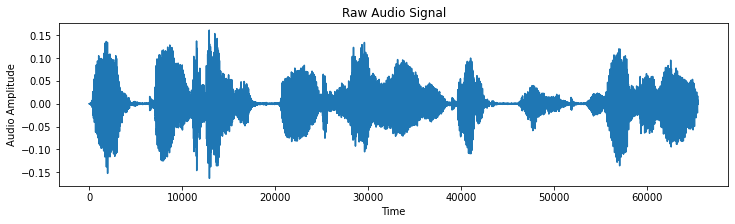

Shape of MFCC: (296, 13)


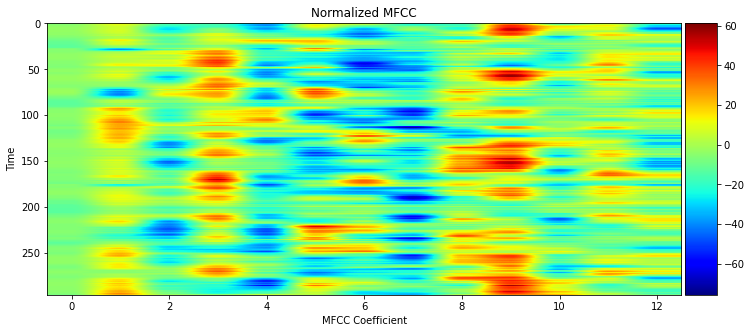

In [ ]:
def visualize(index):
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)
    
    audio, sr = load_and_trim(path)  ## Sampling rate is 22050 Hz
    #print(sr)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
    return path

Audio(visualize(0))  # Audio is the object 

In [ ]:
## obtain all audio file corresponding to MFCCs features
total = len(train_corpus)
features = []
for i in tqdm(range(total)):
    path = paths[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
print(len(features), features[0].shape)

100%|██████████| 178/178 [02:11<00:00,  1.36it/s]

178 (296, 13)


In [ ]:
# Normalized the MFCCs feature
samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

In [ ]:
# build up a dictionary which consists of 2883 different words
chars = {}
for text in texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1

In [ ]:
chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100])

47 [' ', 'e', 'a', 'n', 'i', 't', 's', 'h', 'o', 'r', 'l', 'y', 'm', 'd', 'c', 'u', 'I', 'p', 'g', 'f', 'w', 'b', 'k', '.', 'v', "'", 'M', 'W', ',', 'T', 'j', 'z', '?', 'x', 'A', '-', 'E', 'S', 'C', 'Y', 'L', 'F', 'D', '2', 'G', 'q', '!']


In [ ]:
char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}

In [ ]:
# Spilt the dataset into training set and evaluation set, and define the batch dataset function
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

In [ ]:
train_index

array([107,  27,  60,  79,  63,  93, 172, 133,  95,  45, 142, 146, 173,
       152,   2,  24, 174,  30,  64,  96,  49,  66, 135,  19,  22, 157,
       105, 103,  58,  88,  20,  10,  71, 108, 131,  29, 149,  69,  76,
        43, 129, 162,  21,  55,  17, 166,  41, 118,  57, 117, 116, 101,
       132, 115,   7,  35, 109, 156, 114, 123,  61, 111,  82, 139,  14,
        74,  87,  59,  40, 104, 138,  50, 113, 147, 134, 126,  34, 176,
         6, 128,  85,  48,  53, 151, 158, 122,  80,  38, 169, 159,  18,
        86,  62, 175,  13,  12,  99,   3,  67,  72,  11,  28, 121, 100,
        23,  52,  39, 110, 150, 119, 136,   5,  46, 124,  16,  47,  42,
       144, 106,   9, 140,  56,   4,  44,  78,  51,  15,   8,  90,  31,
       120, 145,  91,  70, 143, 165, 141,  81,  32,  94,  73, 153, 171,
         0, 177, 164, 163,  68, 167,  92,  97, 127,  75,  36,  77, 161,
       155, 102,  83,  33])

In [ ]:
test_index

array([130, 154,  98, 168,  37, 137,  54,  84, 112,  25, 148, 160, 125,
         1,  65, 170,  89,  26])

In [ ]:
X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

In [ ]:
batch_size = 16

In [ ]:
def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        
        yield (inputs, outputs)

In [ ]:
# Define the parameters and model architecture, then start to train the model
epochs = 50
num_blocks = 3
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

In [ ]:
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    
    return Add()([ha, inputs]), hs

In [ ]:
h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

In [ ]:
def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

In [ ]:
ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

In [ ]:
checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 16,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // batch_size)

ValueError: ignored

In [ ]:
# save the model and the dictionary
sub_model.save('asr.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

# plot the loss function during the training process
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()